In [1]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

annotation = '/data/coco/annotations/instances_val2014.json'
dataset = COCO(annotation)

def crop_by_bbox(img, bbox):
    x, y, w, h = bbox
    return img[y:y+h, x:x+w]

def crop_by_bbox_pil(img, bbox):
    x, y, w, h = bbox
    return img.crop((x, y, x+w, y+h))

def resize(img, target_dim):
    img = img.resize(target_dim)
    return np.array(img)

# Write a function that takes in a list of images and draws them in a grid
def draw_images(images, rows, cols):
    fig = plt.figure(figsize=(10, 10))
    for i in range(1, rows*cols + 1):
        fig.add_subplot(rows, cols, i)
        plt.imshow(images[i-1])

    axes = fig.get_axes()
    for ax in axes:
        ax.axis('off')
        
    plt.show()

loading annotations into memory...
Done (t=2.02s)
creating index...
index created!


In [2]:
def get_imgs_cat_id(dataset, cat_id, TARGET_DIM=(50,50), n_imgs=None):
    anns = dataset.getAnnIds(catIds=[cat_id])[:n_imgs]
    img_list = []

    for a_id in anns:
        
        ann = dataset.anns[a_id]
        if 'bbox' not in ann:
            continue

        bbox = [int(d) for d in ann['bbox']]
        img_name = dataset.imgs[ann['image_id']]['file_name']
        img = Image.open('/data/coco/val2014/{}'.format(img_name)).convert('RGB')
        cropped_img = crop_by_bbox_pil(img, bbox)
        cropped_img = resize(cropped_img, TARGET_DIM)

        img_tuple = (img_name, a_id, cropped_img.flatten())
        img_list.append(img_tuple)

        if n_imgs and len(img_list) >= n_imgs:
            break
    
    return img_list

def preprocess_img_list(img_list):
    img_list = np.array(img_list)
    img_list_norm = (img_list - img_list.mean()) / img_list.std()
    return img_list_norm

# Clustering Methods

In [22]:
from sklearn.cluster import KMeans
import umap
import hdbscan
from collections import Counter

def get_kmeans_clusters(img_list, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, max_iter=350).fit(img_list)
    return kmeans

def get_hdbscan_clusters(img_list, min_cluster_size=10, method='eom'):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, cluster_selection_method=method)
    clusterer.fit(img_list)
    return clusterer

def get_umap_embedding(img_list, n_neighbors=5, min_dist=0.3, n_components=2):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components)
    embedding = reducer.fit_transform(img_list)
    return embedding

def plt_umap(embedding, labels):
    # plot non-negative labels
    non_neg = labels >= 0
    plt.figure()
    plt.scatter(embedding[non_neg, 0], embedding[non_neg, 1], c=labels[non_neg], cmap='Spectral', s=5)
    # plot negative labels with alpha
    neg = labels < 0
    plt.scatter(embedding[neg, 0], embedding[neg, 1], c='k', alpha=0.05, s=5)


def get_cluster_quality(X, labels):
    from sklearn.metrics import silhouette_samples
    sample_silhouette_values = silhouette_samples(X, labels)
    return np.mean(sample_silhouette_values)

def get_top_clusters(X, labels, n=2):
    scores = Counter()
    for label in set(labels):
        scores[label] = get_cluster_quality(X, labels == label)
    
    print(scores, scores.most_common(n))
    return scores.most_common(n)

In [173]:
import math


TARGET_DIM = (30,30)
APPLY_FILTER = True

cat_id = 3
img_data = get_imgs_cat_id(dataset, cat_id=cat_id, n_imgs=4000, TARGET_DIM=TARGET_DIM)

In [194]:
img_list = [d[2] for d in img_data]
img_norm = preprocess_img_list(img_list)

In [195]:
np.array(img_list).shape

(4000, 2700)

In [196]:
import math

if APPLY_FILTER:
    # Get top quarter of all images only
    idim = img_norm.shape[1]
    img_norm = img_norm[:, math.floor(idim/2):]

print(img_norm.shape)

(4000, 1350)


In [209]:
MIN_SUPP = 0.01
MIN_DIST = 0.1
N_NEIGHBORS = 15
N_COMPONENTS = 30
K_CLUSTERS = 20
img_u = get_umap_embedding(img_norm, n_neighbors=N_NEIGHBORS, min_dist=MIN_DIST, n_components=N_COMPONENTS)
# normalize embedding
img_u = (img_u - img_u.mean()) / img_u.std()

min_size = int(math.ceil(MIN_SUPP * len(img_list)))
hdb_u_labels = get_hdbscan_clusters(img_u, min_cluster_size=min_size, method='leaf')
hdb_u_labels_eom = get_hdbscan_clusters(img_u, min_cluster_size=min_size, method='eom')

kmeans_u_labels = get_kmeans_clusters(img_u, n_clusters=K_CLUSTERS)
kmeans_norm_labels = get_kmeans_clusters(img_norm, n_clusters=K_CLUSTERS)

/nethome/jxu680/miniconda3/envs/slice-bench/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/nethome/jxu680/miniconda3/envs/slice-bench/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


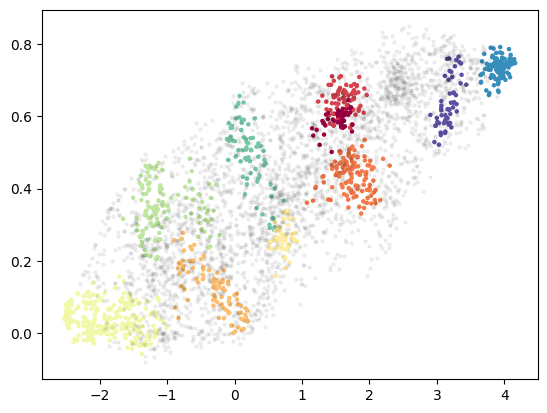

In [206]:
plt_umap(img_u, hdb_u_labels.labels_)

Counter({3: 0.2946324, 6: 0.2623277, -1: 0.11788046, 9: -0.009626592, 2: -0.033341974, 0: -0.13826358, 5: -0.14322726, 1: -0.14404905, 7: -0.17846021, 8: -0.20441388, 4: -0.25859162}) [(3, 0.2946324), (6, 0.2623277), (-1, 0.11788046), (9, -0.009626592), (2, -0.033341974), (0, -0.13826358), (5, -0.14322726), (1, -0.14404905), (7, -0.17846021), (8, -0.20441388), (4, -0.25859162)]
0.2946324


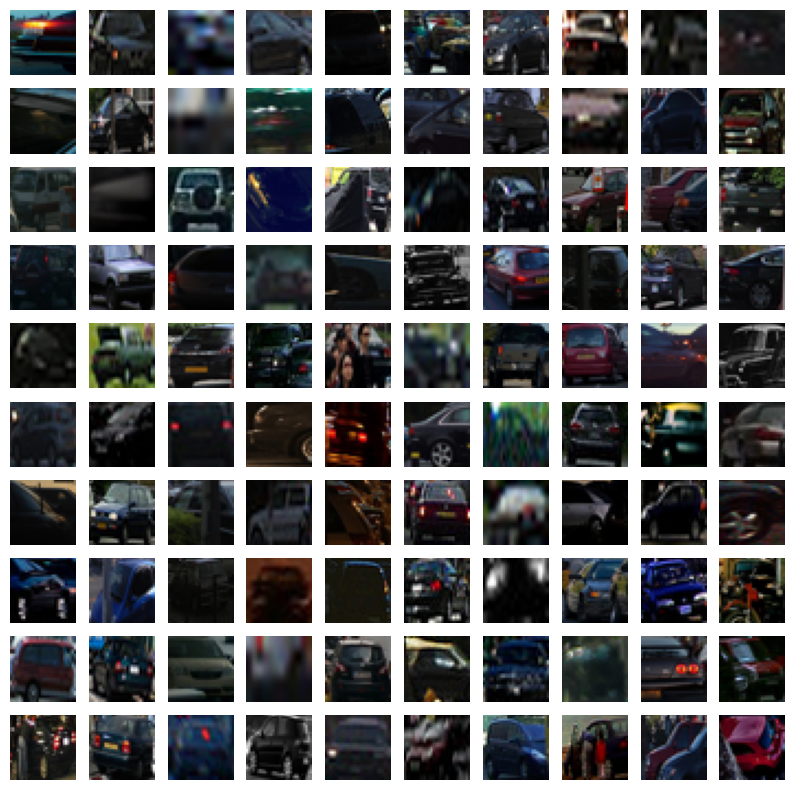

0.2623277


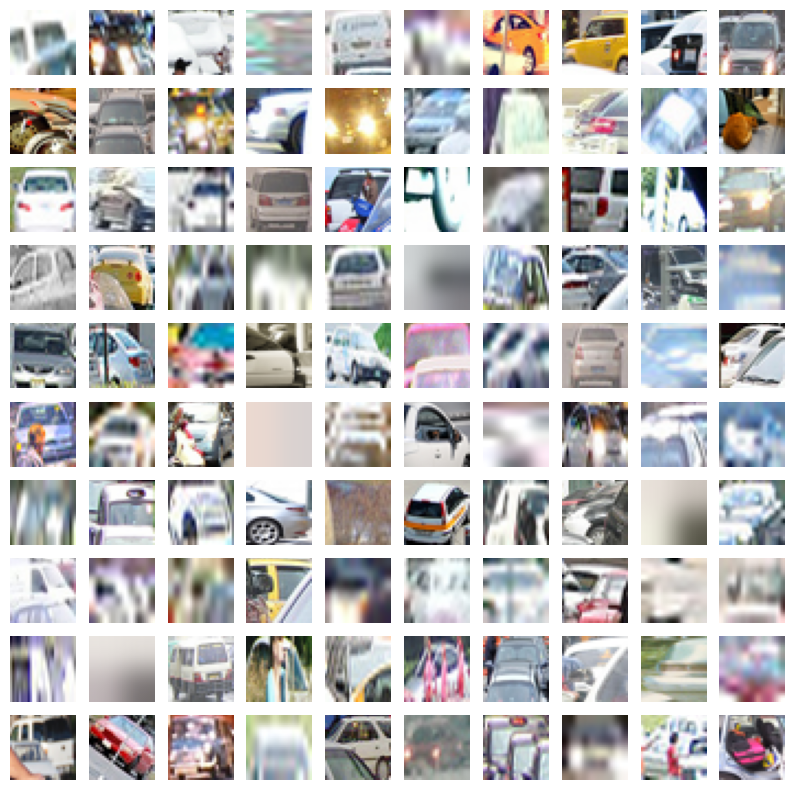

NEAGATIVE
-0.009626592


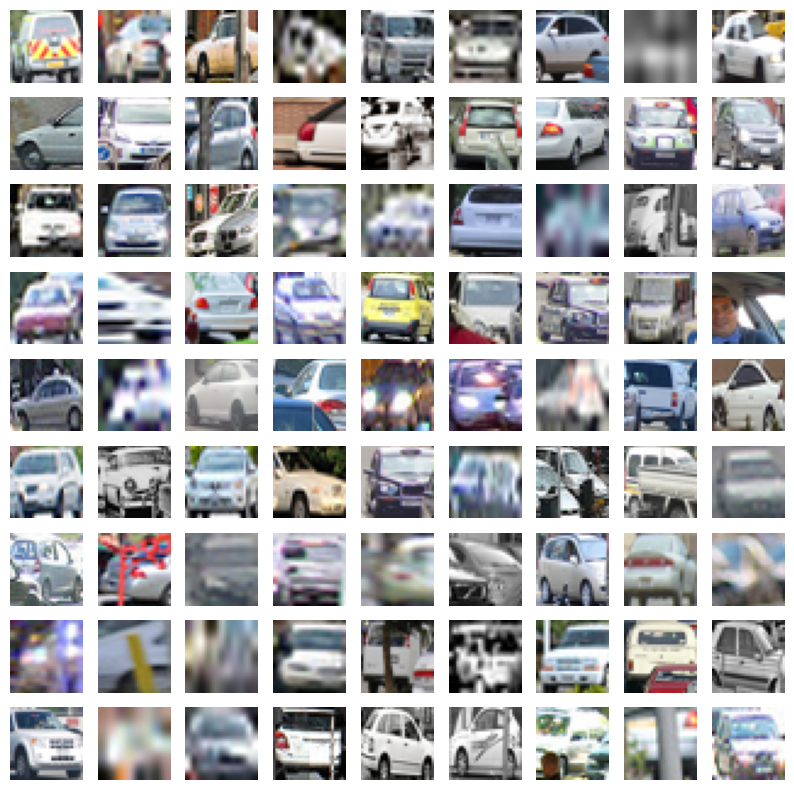

NEAGATIVE
-0.033341974


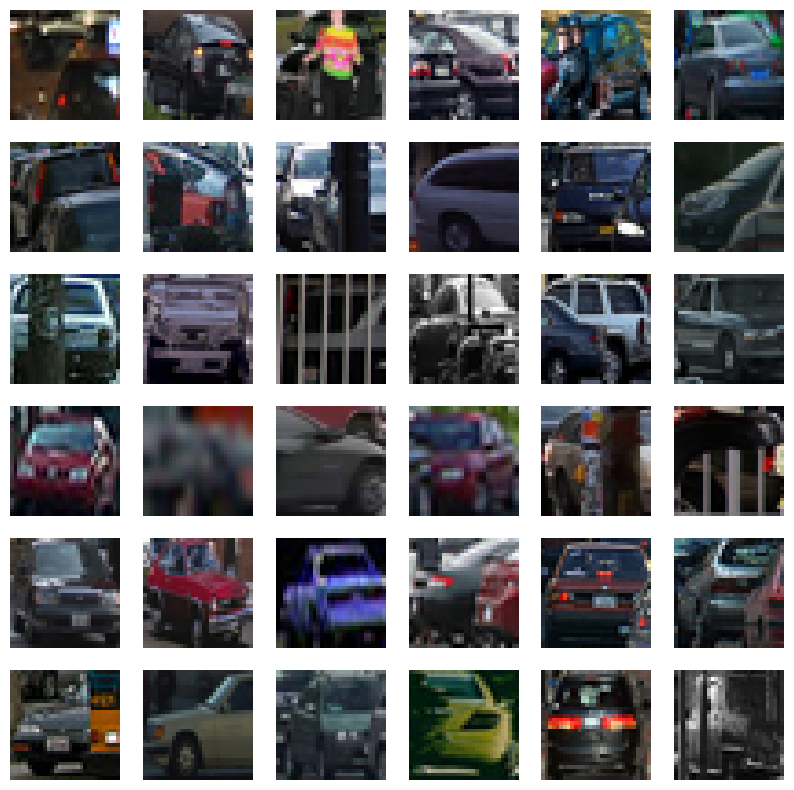

NEAGATIVE
-0.13826358


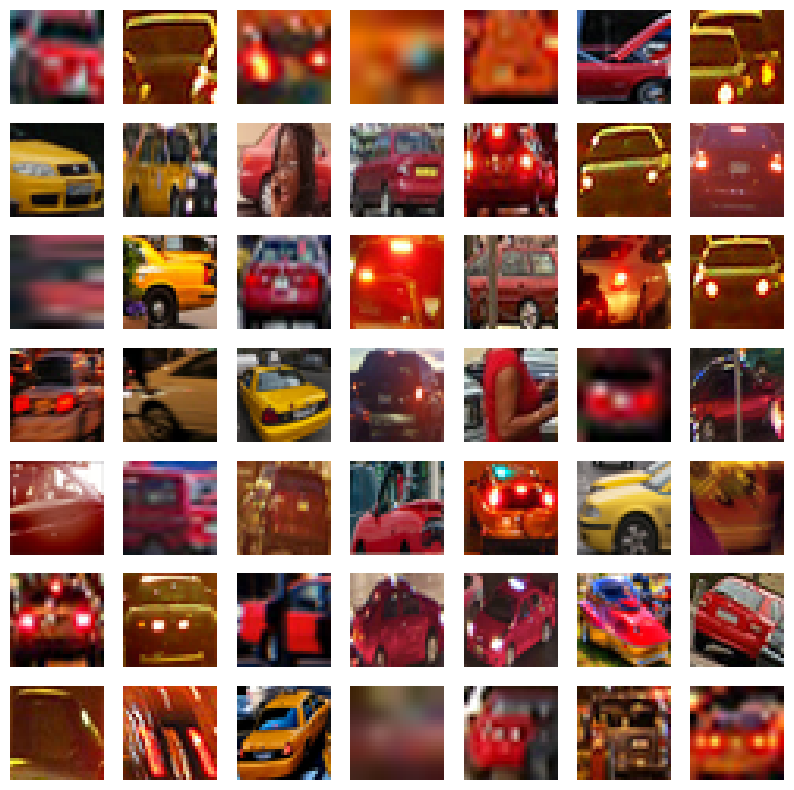

NEAGATIVE
-0.14322726


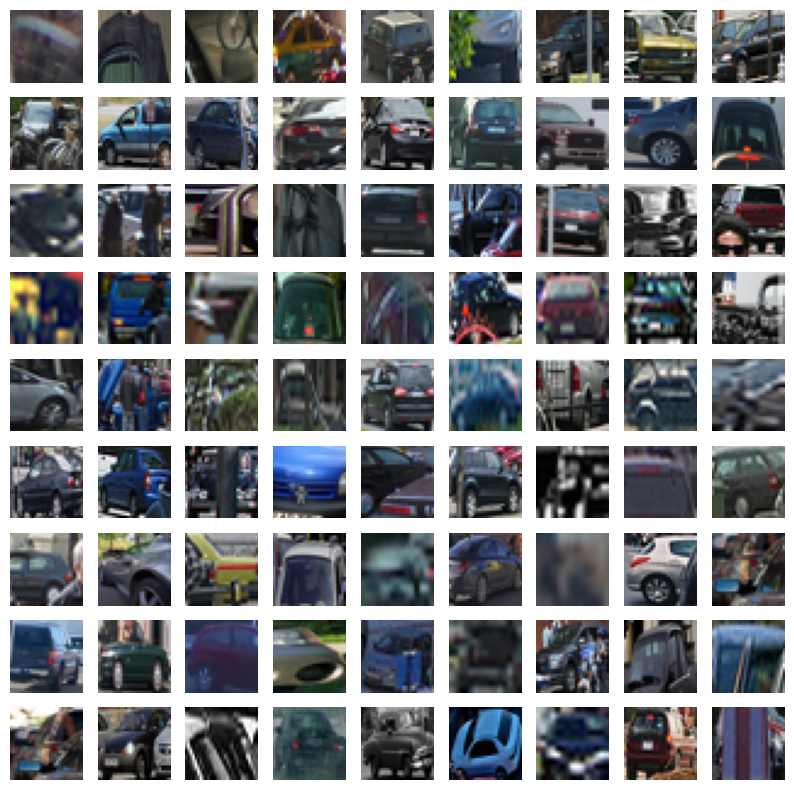

NEAGATIVE
-0.14404905


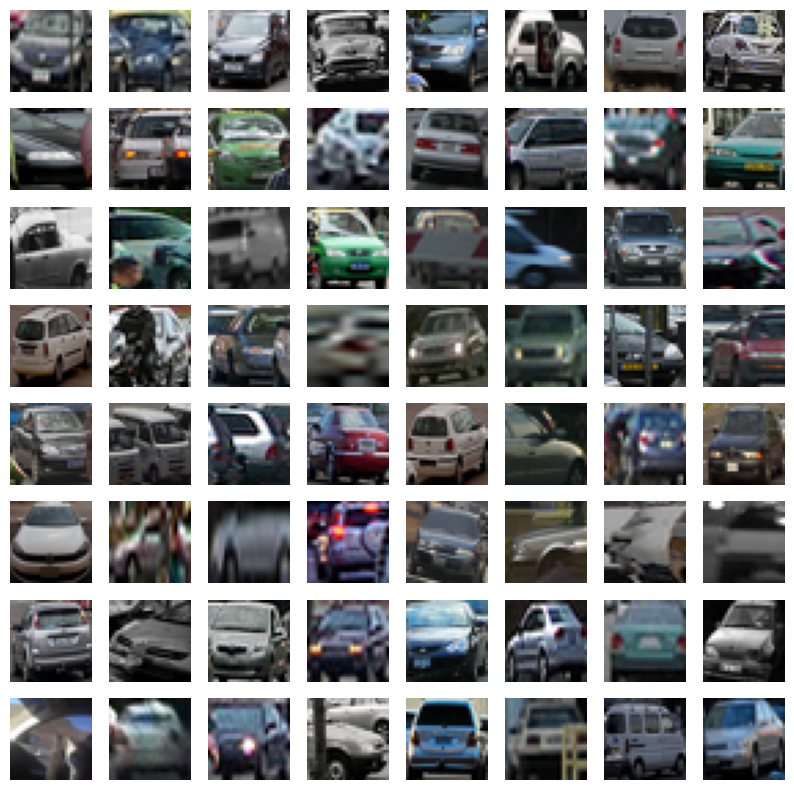

NEAGATIVE
-0.17846021


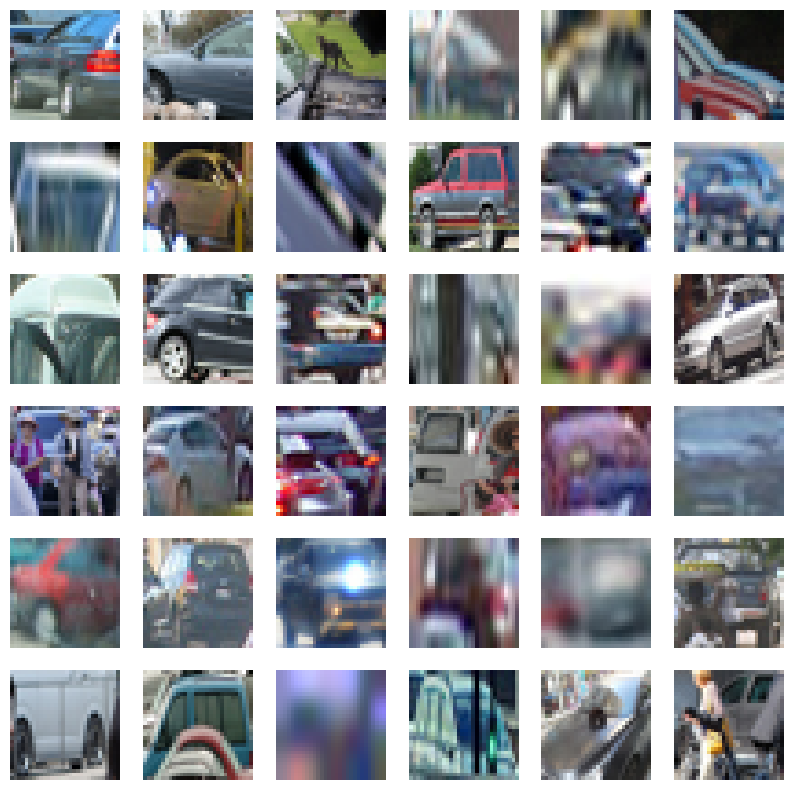

NEAGATIVE
-0.20441388


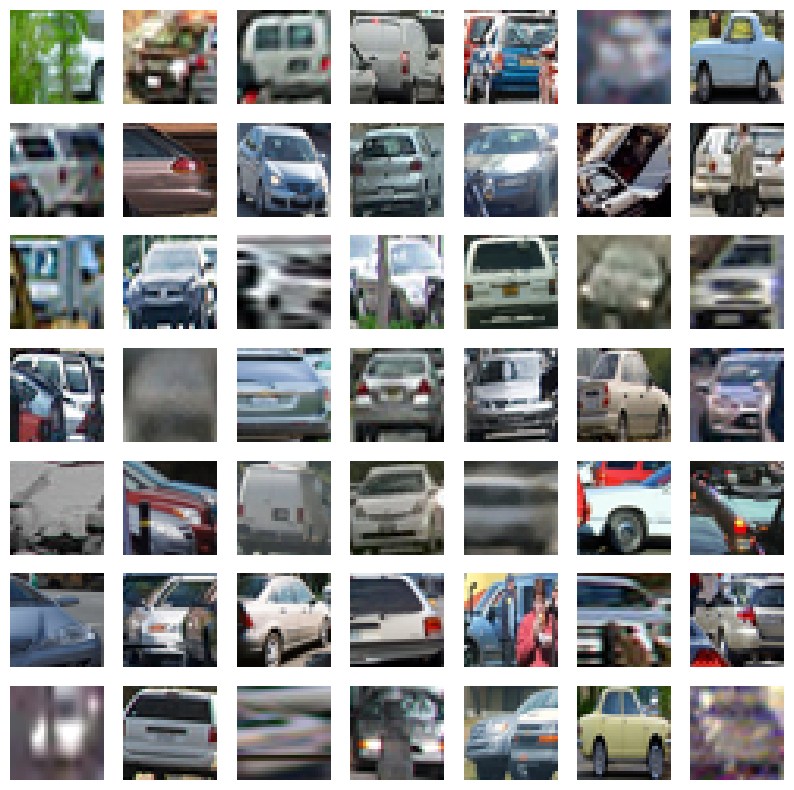

NEAGATIVE
-0.25859162


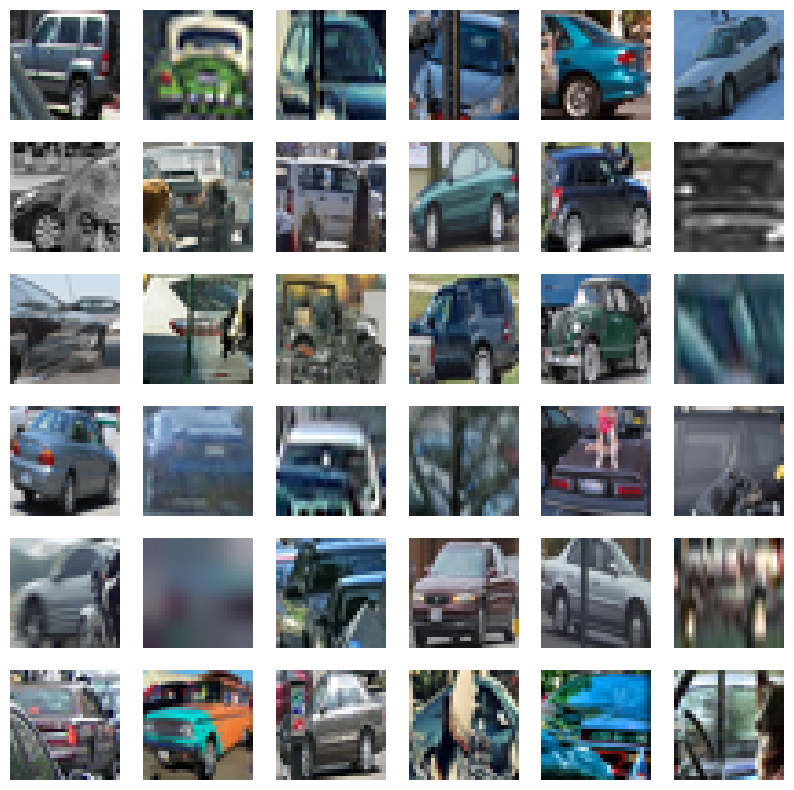

In [210]:
import math
n = 10


# hdb_u_clusters = get_top_clusters(img_u, kmeans_norm_labels.labels_, n=len(set(kmeans_norm_labels.labels_)))
# source = kmeans_norm_labels.labels_

# hdb_u_clusters = get_top_clusters(img_u, kmeans_u_labels.labels_, n=len(set(kmeans_u_labels.labels_)))
# source = kmeans_u_labels.labels_

hdb_u_clusters = get_top_clusters(img_u, hdb_u_labels.labels_, n=len(set(hdb_u_labels.labels_)))
source = hdb_u_labels.labels_

# hdb_u_clusters = get_top_clusters(img_u, hdb_u_labels_eom.labels_, n=len(set(hdb_u_labels_eom.labels_)))
# source = hdb_u_labels_eom.labels_

# sort by score
hdb_u_clusters = sorted(hdb_u_clusters, key=lambda x: x[1], reverse=True)

for (label, score) in hdb_u_clusters:
    if label == -1:
        continue

    if score < 0:
        print('NEAGATIVE')
        #continue

    print(score)

    # source = hdb_u_labels.labels_
    idx = np.where(source == label)[0]
    n_size = math.floor(min(n, math.sqrt(len(idx))))
    idx = np.random.choice(idx, n_size**2, replace=False)
    draw_images([Image.fromarray(img_list[i].reshape(*TARGET_DIM, 3)) for i in idx], n_size, n_size)